# Comparing Temperatures and Luminosities Between Analyses

This notebook measures global temperatures and luminosities for the samples we are using to verify our method, then compares them to the measurements from literature. While the focus of this work is the measurement of galaxy cluster masses, temperatures and luminosities play an important role in the construction of X-ray mass-observable scaling relations - thus they must also be shown to be consistent with previous work. 

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs3p_colour, xcs_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 90
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sources import GalaxyCluster
from xga.sources import BaseSource
from xga.xspec import single_temp_apec

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### SDSSRM-XCS Volume Limited

This is the recent SDSSRM-XCS sample. The temperatures and luminosities are measured by the XCS luminosity-temperature pipeline, and with this we demonstrate that XGA temperatures and luminosities are consistent with existing XCS results.

In order to achieve maximum consistency, we use the XAPA coordinates as the central position for spectrum generation (turning off the XGA peak finder with `use_peak=False`). We have also made sure to use the same cosmology.

Two files are read in here, one with the results of the XCS3P luminosity-temperature pipeline measured within $R_{500}$ and another with results measured within $R_{2500}$. Not all clusters in the $R_{500}$ sample have a corresponding $R_{2500}$.

In [2]:
xcs3p = pd.read_csv("../../sample_files/xcs3p_sdssrm_clusters.csv")
xcs3p_w_r2500 = xcs3p[~np.isnan(xcs3p['r2500'])]

In [3]:
xcs3p_w_r2500

,name,MEM_MATCH_ID,xapa_ra,xapa_dec,z,r500,r500-,r500+,Tx_500,Tx_500-,...,Tx_2500+,Lx52_2500,Lx52_2500-,Lx52_2500+,Lx_2500,Lx_2500-,Lx_2500+,richness,richness_err,XCS_NAME
0,SDSSXCS-124,124,0.800578,-6.091818,0.247483,1181.028159,21.202221,23.202641,6.87647,0.122843,...,0.115250,3.843996,0.014763,0.015042,15.818319,0.153264,0.156050,109.550186,4.489680,XMMXCS J000312.1-060530.5
1,SDSSXCS-2789,2789,0.955540,2.068019,0.105285,1007.860978,17.194150,17.201505,4.61426,0.083565,...,0.065420,0.681434,0.003063,0.002801,2.179112,0.017152,0.018509,38.904396,2.830206,XMMXCS J000349.3+020404.8
2,SDSSXCS-290,290,2.722639,29.161021,0.348495,913.052256,30.878754,31.209675,4.81756,0.265472,...,0.228958,2.075738,0.034854,0.039299,7.045864,0.180983,0.201415,105.095730,5.994321,XMMXCS J001053.4+290939.6
3,SDSSXCS-1018,1018,4.406325,-0.876192,0.214403,902.259231,22.444665,23.366414,4.18272,0.152068,...,0.106573,0.599510,0.005920,0.005900,1.856514,0.029981,0.028809,56.996796,3.219202,XMMXCS J001737.5-005234.2
4,SDSSXCS-134,134,4.908390,3.609818,0.277304,1123.320736,19.219312,19.225964,6.52537,0.104618,...,0.122057,3.590671,0.015225,0.015905,14.457027,0.149038,0.138970,108.604380,4.792484,XMMXCS J001938.0+033635.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,SDSSXCS-11154,11154,349.590000,18.734000,0.160062,894.851382,19.969991,20.027053,3.93910,0.118567,...,0.088772,1.097265,0.008391,0.009392,3.283571,0.042653,0.045900,29.064940,2.978542,XMMXCS J231821.6+184353.2
145,SDSSXCS-2092,2092,350.353080,19.754217,0.328201,781.325350,32.932835,33.420956,3.74304,0.255891,...,0.208170,0.578721,0.012107,0.012321,1.718689,0.057676,0.053950,57.317154,3.997723,XMMXCS J232124.7+194515.1
147,SDSSXCS-68,68,354.410880,0.270705,0.300570,1181.483182,29.206861,29.247086,7.27391,0.248767,...,0.231654,3.917174,0.030554,0.033842,16.666052,0.297638,0.321196,126.330660,4.886888,XMMXCS J233738.6+001614.5
148,SDSSXCS-147,147,355.319370,-9.024678,0.259350,1143.058429,23.680648,25.080662,6.70230,0.170013,...,0.132861,1.748868,0.011151,0.011505,6.704430,0.084191,0.078815,104.470276,4.512718,XMMXCS J234116.6-090128.8


In [4]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xcs3p['xapa_ra'].values
dec = xcs3p['xapa_dec'].values
z = xcs3p['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = xcs3p['name'].values
# In kpc
r500 = Quantity(xcs3p['r500'].values, 'kpc')

# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = xcs3p['richness'].values
r_err = xcs3p['richness_err'].values

# Declaring the actual ClusterSample instance for the XCS sample
xcs_srcs = ClusterSample(ra, dec, z, n, r500=r500, richness=r, richness_err=r_err, cosmology=xcs_cosmo, 
                         load_fits=True, use_peak=False, clean_obs=True, clean_obs_reg='r500', 
                         clean_obs_threshold=0.7)

Generating products of type(s) expmap: 100%|██████████████████████████████████| 52/52 [00:02<00:00, 18.81it/s]


Also define another sample with a subset of those clusters, specifically for those clusters that also have an $R_{2500}$ value as measured by the XCS3P luminosity temperature pipeline. A separate sample in this case makes it easier to run XGA measurements of temperature and luminosity within $R_{2500}$ - this is partially because not all SDSSRM-XCS clusters have a $R_{2500}$ estimate, and partially because we need to define different background regions for $R_{2500}$ regions:

In [5]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xcs3p_w_r2500['xapa_ra'].values
dec = xcs3p_w_r2500['xapa_dec'].values
z = xcs3p_w_r2500['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = xcs3p_w_r2500['name'].values
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = xcs3p_w_r2500['richness'].values
r_err = xcs3p_w_r2500['richness_err'].values
# In kpc, we still include the R500 as we wish to perform the same observation selection as above
r500 = Quantity(xcs3p_w_r2500['r500'].values, 'kpc')
# And we read out the r2500 as well, of course
r2500 = Quantity(xcs3p_w_r2500['r2500'].values, 'kpc')

# Slightly annoying but at the moment I have only let XGA take one set of factors for deciding a background 
#  region, so I also have to define a blanket one for this. As this will be used to measure R2500 quantities 
xcs_srcs_subset = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, richness=r, richness_err=r_err, 
                                cosmology=xcs_cosmo, load_fits=True, use_peak=False, clean_obs=True, 
                                clean_obs_reg='r500', clean_obs_threshold=0.7, back_inn_rad_factor=2, 
                                back_out_rad_factor=3)

Setting up Galaxy Clusters: 100%|███████████████████████████████████████████| 133/133 [03:52<00:00,  1.75s/it]


## Running $T_{\rm{X}}$ and $L_{\rm{X}}$ Measurements

The XGA XSPEC functions that we use here all automatically call the XGA SAS interface, so the necessary spectra are generated before the fits begin. As the different samples measure properties within different spatial regions, all the function calls differ slightly.

The results of the fits are stored within the indivual source objects that make up each sample.

###  Measurements within $R_{500}$

For our comparisons here we wish to measure the temperature ($T_{\rm{X}}$) and luminosity ($L_\rm{X}$; both in the 0.5-2.0 keV and bolometric keV energy bands) within $R_{\rm{500}}$. We fit a `constant*tbabs*apec` model; with the choices for absorption (`tbabs`) and plasma emission (`tbabs`) consistent with the XCS analysis, though the addition of a multiplicative constant to manage differences in sensitivity is different from the original analysis.

In [6]:
single_temp_apec(xcs_srcs, xcs_srcs.r500, timeout=timeout, one_rmf=False)

Running XSPEC Fits: 100%|█████████████████████████████████████████████████| 150/150 [1:39:38<00:00, 39.86s/it]


### Measurements within 0.15-1$R_{500}$

Though we aren't comparing to any core-excised measurements for the SDSSRM-XCS sample, we might as well generate and fit spectra with the core excised. That way we can also create scaling relations with core-excised properties if we want to later.

In [7]:
single_temp_apec(xcs_srcs, xcs_srcs.r500, inner_radius=0.15*xcs_srcs.r500, timeout=timeout, one_rmf=False)

Running XSPEC Fits: 100%|█████████████████████████████████████████████████| 150/150 [2:13:12<00:00, 53.29s/it]


### Measurements within $R_{2500}$

In [8]:
single_temp_apec(xcs_srcs_subset, xcs_srcs_subset.r2500, timeout=timeout, one_rmf=False)

Running XSPEC Fits: 100%|███████████████████████████████████████████████████| 133/133 [44:15<00:00, 19.97s/it]


## Retrieving $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements from the samples

We must extract and judge the quality of the temperature and luminosity measurements that we have made for each of the samples, then later on we will be able to directly compare them. At the same time we make sure that the results from literature are formatted in such a way that we can easily compare them.

### Within $R_{500}$

In [9]:
sdss_tx500 = xcs_srcs.Tx(xcs_srcs.r500, quality_checks=False)

sdss_lxbol500 = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                             hi_en=Quantity(100.0, 'keV'))

sdss_lx500 = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                             hi_en=Quantity(2.0, 'keV'))

In [10]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(sdss_tx500[:, 0]).sum(), 
                                                                  t=len(sdss_tx500)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(sdss_lx500[:, 0]).sum(), 
                                                                    t=len(sdss_lx500)))
print('{s} out of {t} XGA Lxbol measurements were successful'.format(s=np.isfinite(sdss_lxbol500[:, 0]).sum(), 
                                                                    t=len(sdss_lxbol500)))

149 out of 150 XGA Tx measurements were successful
149 out of 150 XGA Lx52 measurements were successful
149 out of 150 XGA Lxbol measurements were successful


### Within [0.15-1]$R_{500}$

In [11]:
sdss_tx500ce = xcs_srcs.Tx(xcs_srcs.r500, inner_radius=0.15*xcs_srcs.r500, quality_checks=False)

sdss_lxbol500ce = xcs_srcs.Lx(xcs_srcs.r500, inner_radius=0.15*xcs_srcs.r500, quality_checks=False, 
                              lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))

sdss_lx500ce = xcs_srcs.Lx(xcs_srcs.r500, inner_radius=0.15*xcs_srcs.r500, quality_checks=False, 
                           lo_en=Quantity(0.5, 'keV'),  hi_en=Quantity(2.0, 'keV'))

In [12]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(sdss_tx500ce[:, 0]).sum(), 
                                                                  t=len(sdss_tx500ce)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(sdss_lx500ce[:, 0]).sum(), 
                                                                    t=len(sdss_lx500ce)))
print('{s} out of {t} XGA Lxbol measurements were successful'.format(s=np.isfinite(sdss_lxbol500ce[:, 0]).sum(), 
                                                                    t=len(sdss_lxbol500ce)))

149 out of 150 XGA Tx measurements were successful
149 out of 150 XGA Lx52 measurements were successful
149 out of 150 XGA Lxbol measurements were successful


### Within $R_{2500}$

In [13]:
sdss_tx2500 = xcs_srcs_subset.Tx(xcs_srcs_subset.r2500, quality_checks=False)

sdss_lxbol2500 = xcs_srcs_subset.Lx(xcs_srcs_subset.r2500, quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                             hi_en=Quantity(100.0, 'keV'))

sdss_lx2500 = xcs_srcs_subset.Lx(xcs_srcs_subset.r2500, quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                             hi_en=Quantity(2.0, 'keV'))

In [14]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(sdss_tx2500[:, 0]).sum(), 
                                                                  t=len(sdss_tx2500)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(sdss_lx2500[:, 0]).sum(), 
                                                                    t=len(sdss_lx2500)))
print('{s} out of {t} XGA Lxbol measurements were successful'.format(s=np.isfinite(sdss_lxbol2500[:, 0]).sum(), 
                                                                    t=len(sdss_lxbol2500)))

133 out of 133 XGA Tx measurements were successful
133 out of 133 XGA Lx52 measurements were successful
133 out of 133 XGA Lxbol measurements were successful


## Investigating a failed measurement

One of the clusters in the SDSSRM-XCS sample has not had a successful temperature measurement within $R_{500}$ (and also within [0.15-1]$R_{500}$. We shall quickly look at this cluster in this section. Firstly we select the failed cluster by finding the NaN entry in our $R_{500}$ temperatures, and using that to index the 'names' array from the cluster sample object:

In [15]:
xcs_srcs.names[np.isnan(sdss_tx500[:, 0])]

array(['SDSSXCS-6307'], dtype='<U13')

### Failed cluster information

We can use the name to extract just the relevant source for convenient access. Running `info()` indicates that the cluster falls on one XMM observation, and has quite a low richness as measured by redMaPPer, indicating it is likely a low mass object:

In [16]:
fail_src = xcs_srcs['SDSSXCS-6307']
fail_src.info()
fail_src.instruments


-----------------------------------------------------
Source Name - SDSSXCS-6307
User Coordinates - (195.66685, 67.47805600000001) degrees
nH - 0.0181 1e+22 / cm2
Redshift - 0.106
XMM ObsIDs - 1
PN Observations - 1
MOS1 Observations - 1
MOS2 Observations - 1
On-Axis - 0
With regions - 1
Total regions - 60
Obs with 1 detection - 1
Obs with >1 matches - 0
Total exposure - 27.18 ks
Images associated - 6
Exposure maps associated - 6
Combined Ratemaps associated - 1
Spectra associated - 6
R500 - 615.05 kpc
R500 SNR - 64.78
Richness - 23.02±1.69
-----------------------------------------------------



{'0136000101': ['pn', 'mos1', 'mos2']}

### Failed cluster ratemaps

Now we view a combined (PN + MOS1 + MOS2, for one observation in this case) ratemap of the cluster, and we indicate the source position as set by the user defined coordinates with a crosshair. Clearly it is a low signal-to-noise cluster, with another extended source very nearby (relatively speaking) in projection:

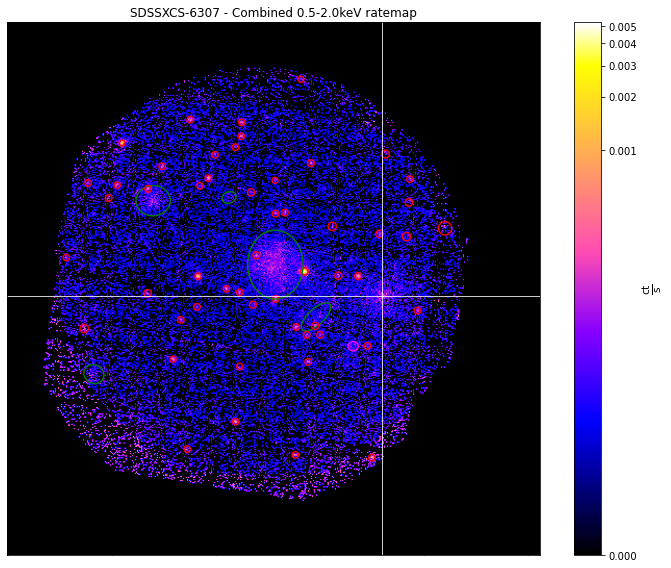

In [17]:
rt = fail_src.get_combined_ratemaps()
rt.regions = fail_src.get_interloper_regions()
rt.view(fail_src.ra_dec, view_regions=True)

We can also remove all sources which XGA considers to be contaminants:

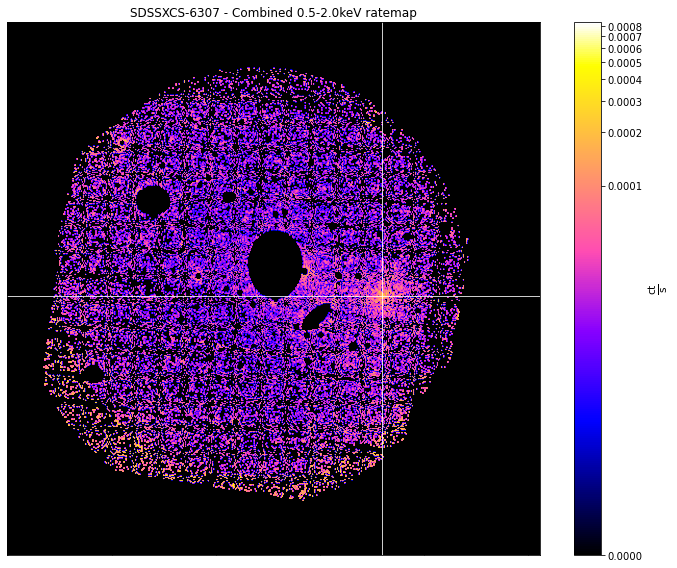

In [18]:
rt.view(fail_src.ra_dec, fail_src.get_interloper_mask())

Finally, we can assess the $R_{500}$ and background regions assigned to the cluster:

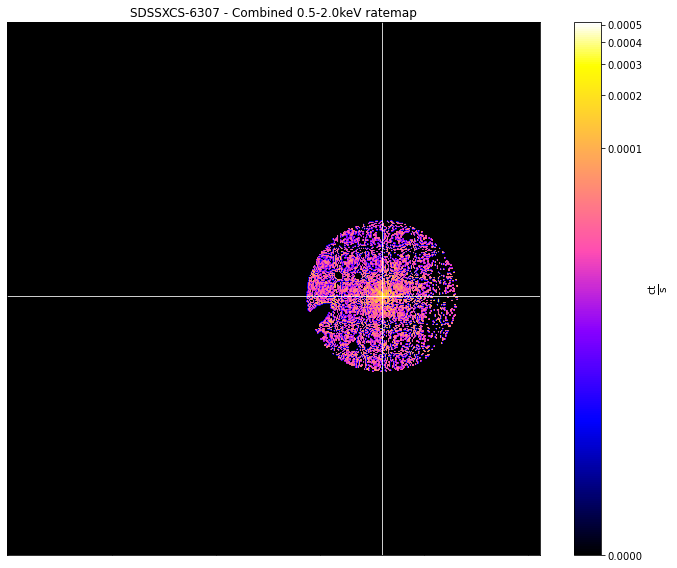

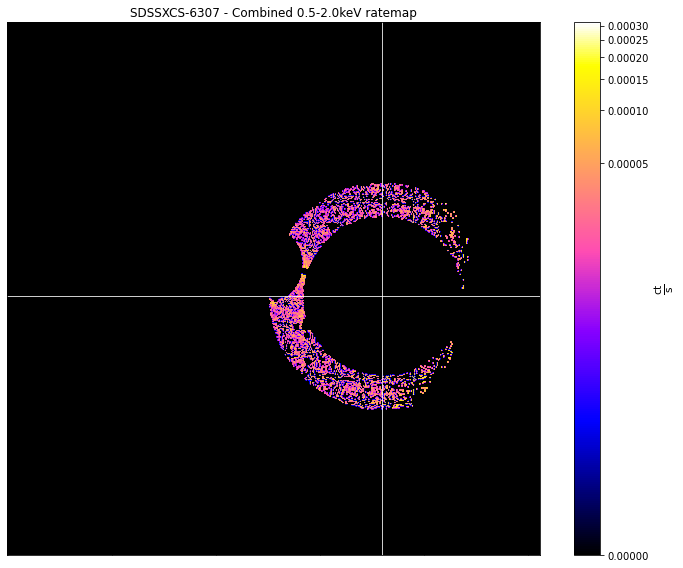

In [19]:
rt.view(fail_src.ra_dec, fail_src.get_mask('r500')[0])
rt.view(fail_src.ra_dec, fail_src.get_mask('r500')[1])

### Failed cluster spectra

We can see that there may be some remnant of contaminating emission from the other extended source present in the background region. This appears to be confirmed when we look at the spectra: 

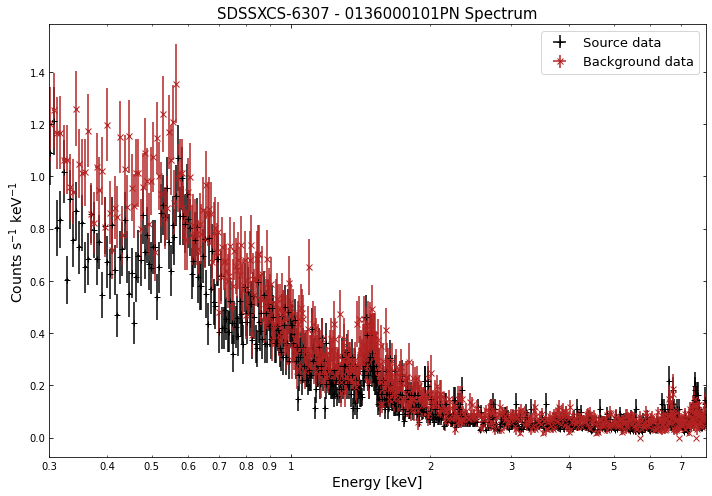

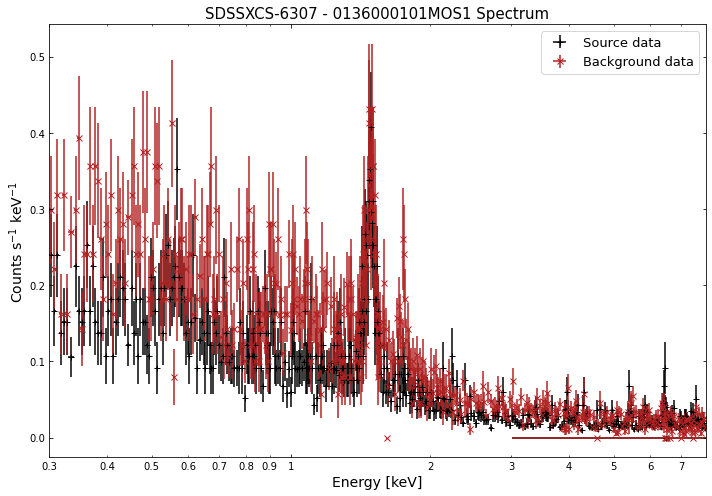

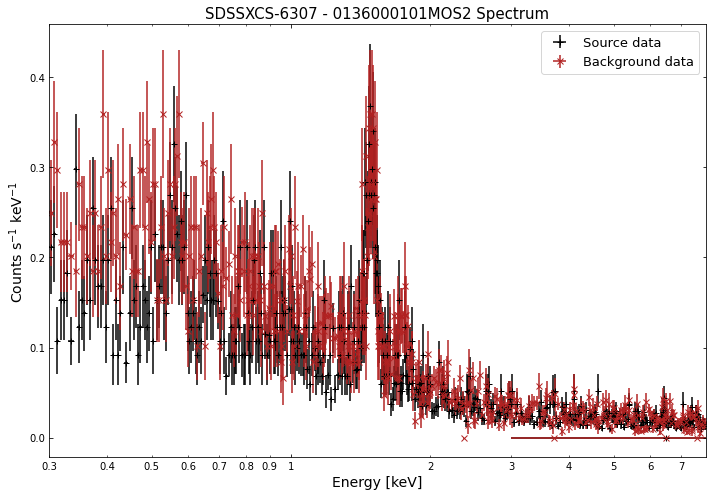

In [20]:
for sp in xcs_srcs['SDSSXCS-6307'].get_spectra('r500'):
    sp.view(back_sub=False)

## Read original XCS3P values

We cycle through the declared XGA cluster samples and use the name of each source to find the matching row in the input catalogue - from there we read out literature measurements. Iterating through the sample isn't strictly necessary for this notebook as all of the clusters in SDSSRM-XCS successfully declare in the cluster sample, but it's better to be safe:

In [21]:
xcs3p_tx_500 = []
xcs3p_lx52_500 = []
xcs3p_lxbol_500 = []
xcs3p_tx_2500 = []
xcs3p_lx52_2500 = []
xcs3p_lxbol_2500 = []

for src in xcs_srcs:
    n = src.name
    rel_row = xcs3p[xcs3p['name'] == n].iloc[0]
    # Extract the XCS3P values within R500 for this cluster
    xcs3p_tx_500.append(Quantity(rel_row[['Tx_500', 'Tx_500-', 'Tx_500+']].values, 'keV'))
    xcs3p_lx52_500.append(Quantity(rel_row[['Lx52_500', 'Lx52_500-', 'Lx52_500+']].values*1e+44, 'erg/s'))
    xcs3p_lxbol_500.append(Quantity(rel_row[['Lx_500', 'Lx_500-', 'Lx_500+']].values*1e+44, 'erg/s'))

for src in xcs_srcs_subset:
    n = src.name
    rel_row = xcs3p[xcs3p['name'] == n].iloc[0]
    # Extract the XCS3P values within R2500 for this cluster
    xcs3p_tx_2500.append(Quantity(rel_row[['Tx_2500', 'Tx_2500-', 'Tx_2500+']].values, 'keV'))
    xcs3p_lx52_2500.append(Quantity(rel_row[['Lx52_2500', 'Lx52_2500-', 'Lx52_2500+']].values*1e+44, 'erg/s'))
    xcs3p_lxbol_2500.append(Quantity(rel_row[['Lx_2500', 'Lx_2500-', 'Lx_2500+']].values*1e+44, 'erg/s'))  

# Convert a list of quantities into a non-scalar, quantity object
xcs3p_tx_500 = Quantity(xcs3p_tx_500)
xcs3p_lx52_500 = Quantity(xcs3p_lx52_500)
xcs3p_lxbol_500 = Quantity(xcs3p_lxbol_500)

xcs3p_tx_2500 = Quantity(xcs3p_tx_2500)
xcs3p_lx52_2500 = Quantity(xcs3p_lx52_2500)
xcs3p_lxbol_2500 = Quantity(xcs3p_lxbol_2500)

## Direct comparisons between original and XGA measurements

This is the the point of this notebook, making direct comparisons of like for like (or as near as we can achieve) measurements from literature to measurements made using XGA. In each case we plot simple one-to-one comparisons, with a one-to-one dashed line in red to give a reference.

We directly compare temperatures and luminosities (soft band and bolimetric) between the XCS3P pipeline and XGA.

### $T_{\rm{X}, 500}$, $L^{\rm{0.5-2.0}}_{\rm{X}, 500}$, and $L^{\rm{bol}}_{\rm{X}, 500}$ 

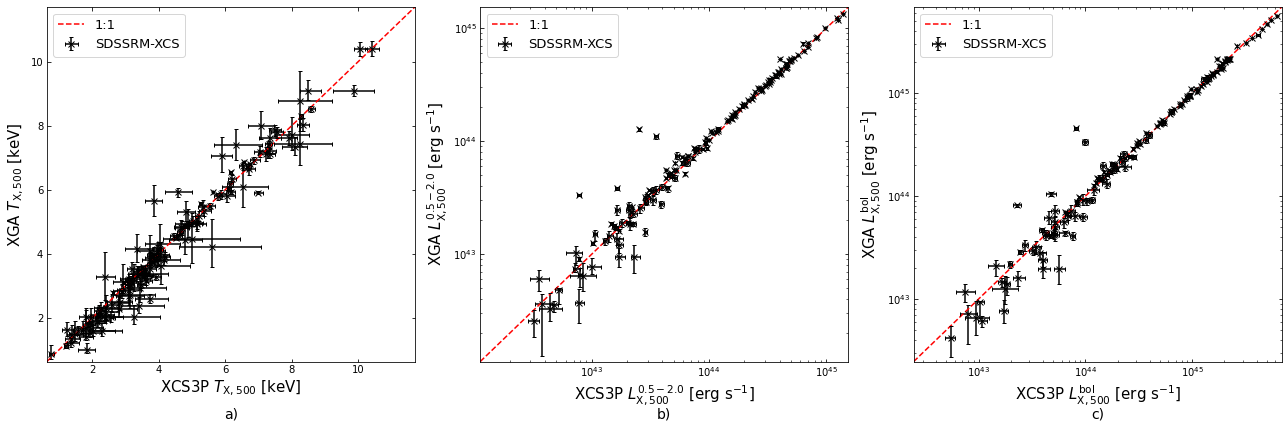

In [22]:
direct_comparison_plot([xcs3p_tx_500, xcs3p_lx52_500, xcs3p_lxbol_500], [sdss_tx500, sdss_lx500, sdss_lxbol500], 
                       [r"XCS3P $T_{\rm{X, 500}}$ [keV]", r"XCS3P $L^{\rm{0.5-2.0}}_{\rm{X, 500}}$ [erg s$^{-1}$]", 
                        r"XCS3P $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]"], 
                       [r"XGA $T_{\rm{X, 500}}$ [keV]", r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 500}}$ [erg s$^{-1}$]", 
                        r"XGA $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]"],
                       r"SDSSRM-XCS", (18, 6), ['linear', 'log', 'log'], ['linear', 'log', 'log'])

100%|██████████████████████████████████████████████████████████████████| 20000/20000 [00:23<00:00, 860.45it/s]


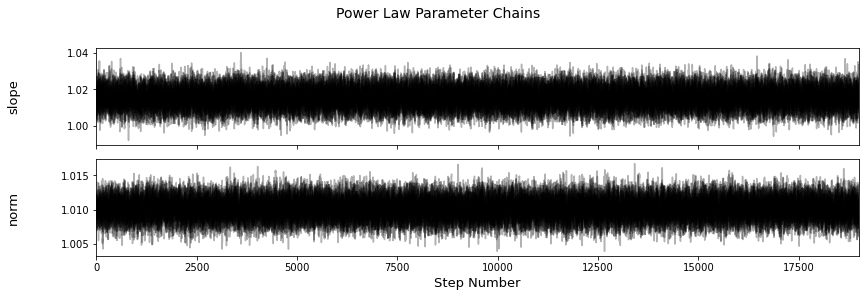

Removed no burn in


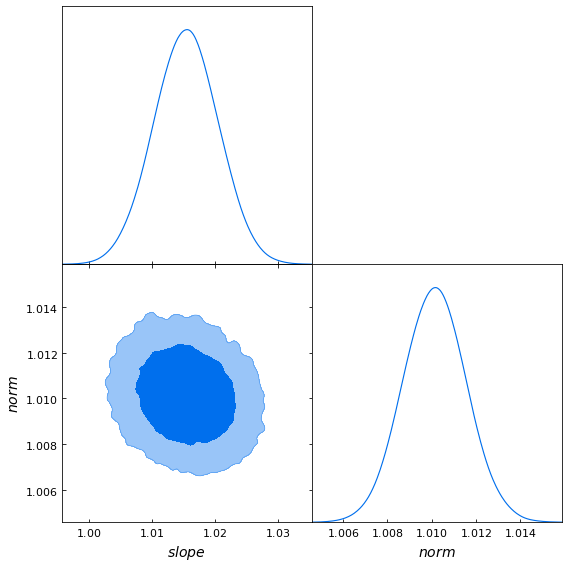

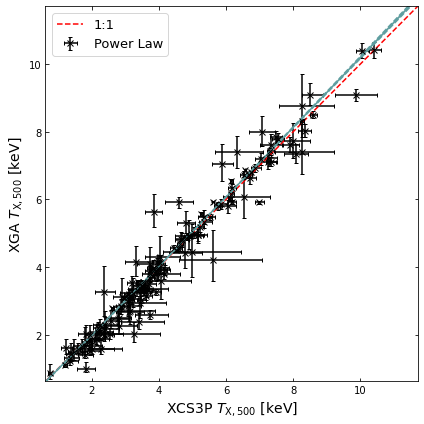

slope=1.015 +0.005 -0.005 [1sig]
norm=1.01 +0.001 -0.001 [1sig]


In [23]:
fit_comp(xcs3p_tx_500, sdss_tx500, [[-5, 5], [-5, 5]], r"XCS3P $T_{\rm{X, 500}}$ [keV]", 
         r"XGA $T_{\rm{X, 500}}$ [keV]", Quantity(5.5, 'keV'),  num_steps=20000, view_chains=True, 
         linear=False, view_corner=True)

### $T_{\rm{X}, 2500}$, $L^{\rm{0.5-2.0}}_{\rm{X}, 2500}$, and $L^{\rm{bol}}_{\rm{X}, 2500}$ 

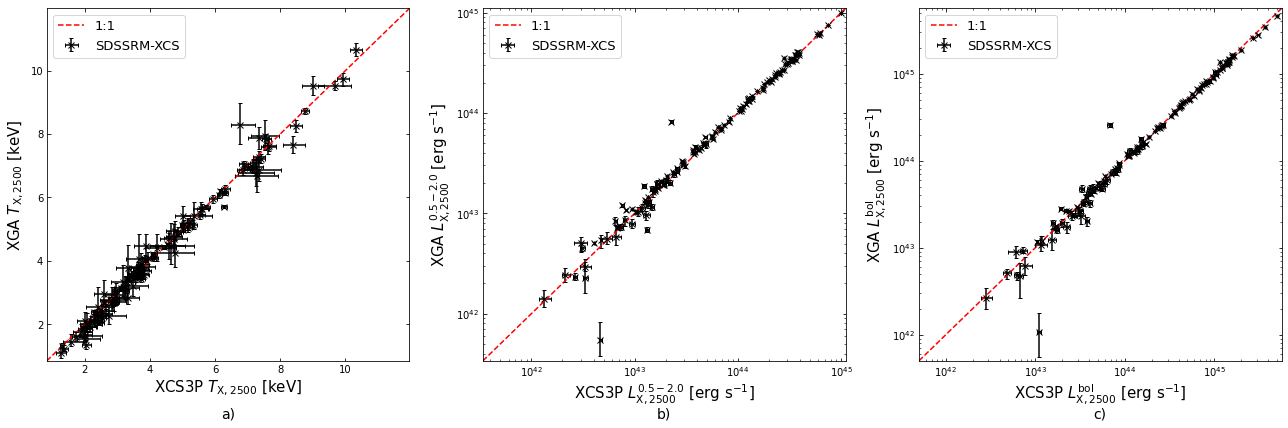

In [24]:
direct_comparison_plot([xcs3p_tx_2500, xcs3p_lx52_2500, xcs3p_lxbol_2500], 
                       [sdss_tx2500, sdss_lx2500, sdss_lxbol2500], 
                       [r"XCS3P $T_{\rm{X, 2500}}$ [keV]", r"XCS3P $L^{\rm{0.5-2.0}}_{\rm{X, 2500}}$ [erg s$^{-1}$]", 
                        r"XCS3P $L^{\rm{bol}}_{\rm{X, 2500}}$ [erg s$^{-1}$]"], 
                       [r"XGA $T_{\rm{X, 2500}}$ [keV]", r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 2500}}$ [erg s$^{-1}$]", 
                        r"XGA $L^{\rm{bol}}_{\rm{X, 2500}}$ [erg s$^{-1}$]"],
                       r"SDSSRM-XCS", (18, 6), ['linear', 'log', 'log'], ['linear', 'log', 'log'])

100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:19<00:00, 1015.29it/s]


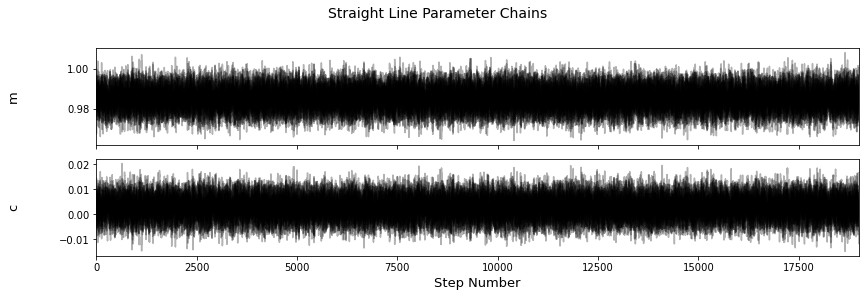

Removed no burn in


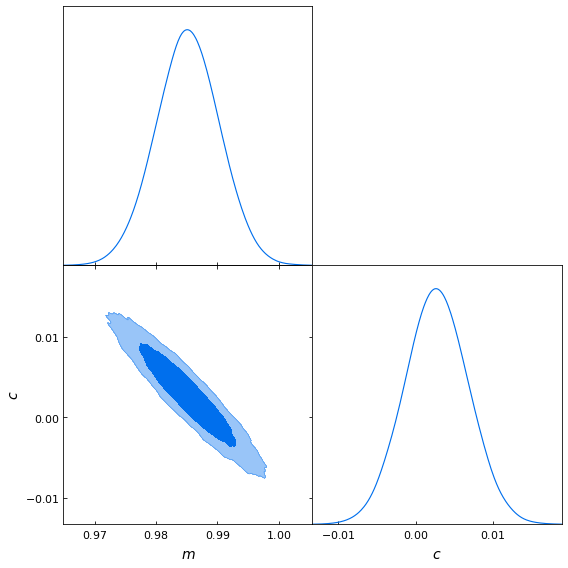

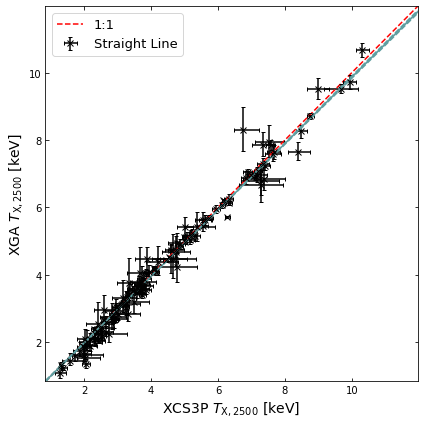

m=0.985 +0.005 -0.005 [1sig]
c=0.003 +0.004 -0.004 [1sig]


In [25]:
fit_comp(xcs3p_tx_2500, sdss_tx2500, [[-5, 5], [-5, 5]], r"XCS3P $T_{\rm{X, 2500}}$ [keV]", 
         r"XGA $T_{\rm{X, 2500}}$ [keV]", Quantity(5.5, 'keV'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)

### $T_{\rm{X, 500}}$ and $T_{\rm{X, 2500}}$ comparison plot

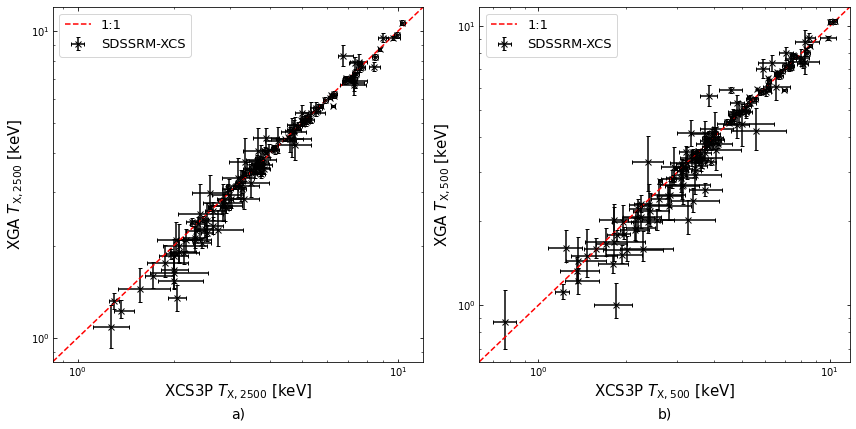

In [26]:
direct_comparison_plot([xcs3p_tx_2500, xcs3p_tx_500], [sdss_tx2500, sdss_tx500], 
                       [r"XCS3P $T_{\rm{X, 2500}}$ [keV]", r"XCS3P $T_{\rm{X, 500}}$ [keV]"], 
                       [r"XGA $T_{\rm{X, 2500}}$ [keV]", r"XGA $T_{\rm{X, 500}}$ [keV]"],
                       r"SDSSRM-XCS", (12, 6), ['log', 'log'], ['log', 'log'], 
                       savepath="../../outputs/figures/sdssrm-xcs_tx500_tx2500_comp.pdf")

## Outputting XGA measured values as a catalogue

The XGA sample object(s) describing our galaxy clusters contain the measured temperature and luminosity values for this sample, but we wish to write them to an easily readable format which can be version controlled:

In [27]:
xga_res_r500 = pd.DataFrame(np.array([xcs_srcs.names.T, sdss_tx500[:, 0].value, sdss_tx500[:, 1].value, 
                                      sdss_tx500[:, 2].value, sdss_lx500[:, 0].value, sdss_lx500[:, 1].value, 
                                      sdss_lx500[:, 2].value, sdss_lxbol500[:, 0].value, sdss_lxbol500[:, 1].value, 
                                      sdss_lxbol500[:, 2].value]).T, 
                            columns=['name', 'Tx_500', 'Tx_500-', 'Tx_500+', 'Lx52_500', 'Lx52_500-', 'Lx52_500+', 
                                     'Lxbol_500', 'Lxbol_500-', 'Lxbol_500+'])
xga_res_r500ce = pd.DataFrame(np.array([xcs_srcs.names.T, sdss_tx500ce[:, 0].value, sdss_tx500ce[:, 1].value, 
                                        sdss_tx500ce[:, 2].value, sdss_lx500ce[:, 0].value, sdss_lx500ce[:, 1].value, 
                                        sdss_lx500ce[:, 2].value, sdss_lxbol500ce[:, 0].value, 
                                        sdss_lxbol500ce[:, 1].value, sdss_lxbol500ce[:, 2].value]).T, 
                              columns=['name', 'Tx_500ce', 'Tx_500ce-', 'Tx_500ce+', 'Lx52_500ce', 'Lx52_500ce-', 
                                       'Lx52_500ce+', 'Lxbol_500ce', 'Lxbol_500ce-', 'Lxbol_500ce+'])
xga_res_r2500 = pd.DataFrame(np.array([xcs_srcs_subset.names.T, sdss_tx2500[:, 0].value, sdss_tx2500[:, 1].value, 
                                       sdss_tx2500[:, 2].value, sdss_lx2500[:, 0].value, sdss_lx2500[:, 1].value, 
                                       sdss_lx2500[:, 2].value, sdss_lxbol2500[:, 0].value, 
                                       sdss_lxbol2500[:, 1].value, sdss_lxbol2500[:, 2].value]).T, 
                            columns=['name', 'Tx_2500', 'Tx_2500-', 'Tx_2500+', 'Lx52_2500', 'Lx52_2500-', 
                                     'Lx52_2500+', 'Lxbol_2500', 'Lxbol_2500-', 'Lxbol_2500+'])

xga_sdssrmxcs_out = pd.merge(xga_res_r500, xga_res_r2500, on='name', how='left')
xga_sdssrmxcs_out = pd.merge(xga_sdssrmxcs_out, xga_res_r500ce, on='name', how='left')

xga_sdssrmxcs_out.to_csv("../../outputs/results/sdssrm-xcs_r500_r2500_txlx.csv", index=False)

xga_sdssrmxcs_out

,name,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,Lx52_500+,Lxbol_500,Lxbol_500-,Lxbol_500+,...,Lxbol_2500+,Tx_500ce,Tx_500ce-,Tx_500ce+,Lx52_500ce,Lx52_500ce-,Lx52_500ce+,Lxbol_500ce,Lxbol_500ce-,Lxbol_500ce+
0,SDSSXCS-124,6.92015,0.1163663749999992,0.1116456080000007,5.31039497e+44,2.78741326743206e+42,3.1567700250829706e+42,2.039771111e+45,1.677717172208926e+43,2.1995695041827132e+43,...,1.356117112969231e+43,6.7805,0.1341177560000002,0.1587507910000001,3.6848614770000005e+44,2.2409757752895203e+42,2.7664214290037003e+42,1.4014643590000002e+45,1.660219856764362e+43,1.8330473974452831e+43
1,SDSSXCS-2789,4.53982,0.0730187390000001,0.074565926,1.029585351e+44,6.398074721961801e+41,7.1196495200908e+41,3.2133869300000004e+44,3.200995689549071e+42,4.07109628638148e+42,...,2.02123725969263e+42,4.65448,0.1085904550000007,0.1136799329999993,6.943673073000001e+43,5.5587402700388e+41,6.3892210942203005e+41,2.1926353080000002e+44,3.46776824730113e+42,3.9271372178919204e+42
2,SDSSXCS-290,5.31695,0.2978612860000007,0.3363328149999995,2.856684648e+44,6.54472721142818e+42,7.48411270792357e+42,9.632633448e+44,3.35779809281957e+43,4.355422977255379e+43,...,2.31748052731493e+43,5.44791,0.4078653150000004,0.4862913049999999,1.9721161830000004e+44,5.3955869232252406e+42,6.56758161122872e+42,6.733913936000001e+44,3.5129996051496983e+43,3.776229287501739e+43
3,SDSSXCS-1018,3.90154,0.1435351899999997,0.1515063040000006,8.044819691000001e+43,9.3834282143052e+41,1.21805300601101e+42,2.3358494040000004e+44,5.31927683020174e+42,6.1174159791675e+42,...,3.4618124153723604e+42,3.93097,0.2072827289999996,0.2304893480000003,5.048988199e+43,1.32324059650829e+42,9.519208841256102e+41,1.471116666e+44,4.971766705815361e+42,5.943493784449331e+42
4,SDSSXCS-134,6.72636,0.1165286779999998,0.1165610109999999,4.8118889700000005e+44,2.6794331430179203e+42,3.09369143483304e+42,1.8253099730000002e+45,1.640494148994027e+43,2.194192161244673e+43,...,1.394391685005643e+43,6.37682,0.1358317790000001,0.1538145749999993,3.4477165880000003e+44,2.18757191329328e+42,2.74024815820107e+42,1.27385174e+45,1.661491239813977e+43,1.8311224289381802e+43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,SDSSXCS-2092,3.79016,0.2344082530000002,0.2652712829999997,8.507385808000001e+43,2.2275574161196703e+42,2.14510378317355e+42,2.4256197770000003e+44,9.977888958687221e+42,1.0144822975391371e+43,...,4.8966495079050206e+42,3.58013,0.25328499,0.2791540050000001,7.037333779000001e+43,1.86929570674396e+42,2.70419793494318e+42,1.9535028740000003e+44,9.21876683707335e+42,1.056885788947643e+43
146,SDSSXCS-17923,1.6847,0.2475581180000001,0.5596640989999997,7.751179601e+42,1.04680787980556e+42,1.5661313990694402e+42,1.6139757330000004e+43,2.6357593084924705e+42,2.7943691338546005e+42,...,NaN,1.77162,0.3400449649999999,1.0724210850000002,6.941284530000001e+42,8.920662545848901e+41,1.6582421612674e+42,1.468818897e+43,2.3130541444554102e+42,3.33529915130074e+42
147,SDSSXCS-68,7.21801,0.2169218919999993,0.2429297310000002,5.4826363430000004e+44,5.81817191483478e+42,6.17626570273061e+42,2.1545267280000004e+45,3.3931983809728024e+43,4.3379667885212087e+43,...,2.34173342491495e+43,6.83479,0.2324467639999996,0.2665085940000002,4.3200541530000006e+44,4.1793522825722305e+42,5.648526557482611e+42,1.652531891e+45,3.5734324639214026e+43,3.305320846362811e+43
148,SDSSXCS-147,6.64643,0.1831473129999992,0.1835153310000006,2.49474295e+44,2.2995728132171503e+42,2.3261515851800503e+42,9.400256691e+44,1.334505654057352e+43,1.519352872581131e+43,...,7.66956734747752e+42,6.4845,0.2200686539999994,0.2363560900000001,1.873435246e+44,1.5459624587276502e+42,1.91076450281517e+42,6.975204316000001e+44,1.104367801902023e+43,1.475085634271531e+43
